# 04e - Vertex AI > Notebooks - Forecasting with Prophet (Python)


### Prerequisites:
-  04 - Time Series Forecasting - Data Review in BigQuery

### Overview:
- Setup
- Time Series Data
    - Forecast Data From BigQuery to Dataframe
    - Prepate Data for Prophet
    - Review a Series Dataframe
- Create Forcast Model - Single Series
- Create Forecast Models - All Series ... In Parallel
    - Create a function to fit a series
    - Test the function on a single series
    - Setup Multiprocessing
    - Run all series in parallel
    - Review predictions for one of the series
- Store the Results back in BigQuery
    - Concatenate the prediction for each series
    - Load the dataframe to BigQuery using Pandas GBQ
    - Use BigQuery to Transform the Results: Combine with Source Data
- Results
    - Retrieve Test Data
    - Review Custom Metrics with SQL
    - Retrieve The Forecating Data
    - Visualize the Time Series with Forecast

### Resources:
- [Prophet Quick Start](https://facebook.github.io/prophet/docs/quick_start.html)

---
## Vertex AI - Conceptual Flow

<img src="architectures/slides/04e_arch.png">

---
## Vertex AI - Workflow

<img src="architectures/slides/04e_console.png">

---
## Setup

add packages: only needed once for the environment

In [2]:
!pip install pystan==2.19.1.1 -U -q
!pip install prophet -U -q
!pip install pandas-gbq -U -q

inputs:

In [7]:
PROJECT_ID='statmike-demo3'
REGION = 'us-central1'
DATANAME = 'citibikes'
NOTEBOOK = '04e'

packages:

In [8]:
from google.cloud import bigquery
from prophet import Prophet

import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

clients:

In [9]:
bigquery = bigquery.Client()

parameters:

environment:

## Time Series Data

### Forecast Data From BigQuery to Dataframe

In [10]:
query = f"""
SELECT *
FROM `{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped`
ORDER by start_station_name, date
"""
source = bigquery.query(query = query).to_dataframe()
source.head()

start_station_name        date  num_trips  \
0  Central Park North & Adam Clayton Powell Blvd  2016-09-01         14   
1  Central Park North & Adam Clayton Powell Blvd  2016-09-02        151   
2  Central Park North & Adam Clayton Powell Blvd  2016-09-03        255   
3  Central Park North & Adam Clayton Powell Blvd  2016-09-04        328   
4  Central Park North & Adam Clayton Powell Blvd  2016-09-05        259   

     splits  
0  VALIDATE  
1  VALIDATE  
2  VALIDATE  
3  VALIDATE  
4  VALIDATE

### Prepare Data for Prophet
Prophet expects a dataframe for a single time series with columns `ds` for timestamp and `y` for the demand variable of the forecast.  This data has multiple series, one for each station identified in the column `start_station_name`.  Below is the code to create a list of station in `seriesNames` and a list of dataframes in `seriesFrames`.

In [11]:
seriesNames = source['start_station_name'].unique().tolist()

seriesFrames = []
for s in seriesNames:
    frame = source[(source['start_station_name']==s) & (source['splits']!='TEST')][['date','num_trips']].rename(columns={'date':'ds','num_trips':'y'})
    seriesFrames.append(frame)

### Review a Series Dataframe

In [13]:
seriesNames[5],seriesFrames[5]

('Central Park West & W 68 St',
               ds    y
 1373  2015-09-01   48
 1374  2015-09-02   75
 1375  2015-09-03   83
 1376  2015-09-04   74
 1377  2015-09-05  173
 ...          ...  ...
 1711  2016-09-10  203
 1712  2016-09-11  200
 1713  2016-09-12  160
 1714  2016-09-13  184
 1715  2016-09-14  121
 
 [343 rows x 2 columns])

---
## Create Forecast Model - Single Series

Fit with seasonality and holidays added:


In [19]:
p = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
p.add_country_holidays(country_name='US')
p.fit(seriesFrames[5])

Initial log joint probability = -8.66172


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       568.308   6.65757e-08       102.119       0.367       0.367      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       568.308   1.71768e-08       100.571       0.579       0.579      129   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Which holidays were considered:

In [21]:
print(p.train_holiday_names)

0                  New Year's Day
1      Martin Luther King Jr. Day
2           Washington's Birthday
3                    Memorial Day
4                Independence Day
5                       Labor Day
6                    Columbus Day
7                    Veterans Day
8                    Thanksgiving
9                   Christmas Day
10       Christmas Day (Observed)
11    Independence Day (Observed)
dtype: object


Make dataframe for forecast by adding periods to the known date range of the training data.  If you only want the forecast horizone then use the option `include_history = False`.

In [22]:
future = p.make_future_dataframe(periods = 16)
future

ds
0   2015-09-01
1   2015-09-02
2   2015-09-03
3   2015-09-04
4   2015-09-05
..         ...
354 2016-09-26
355 2016-09-27
356 2016-09-28
357 2016-09-29
358 2016-09-30

[359 rows x 1 columns]

Generate the predictions for the forecast horizon.  Since we kept the default that include the training history dates, we also get fit information for each of these dates.

In [23]:
forecast = p.predict(future)
forecast

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0   2015-09-01   50.065197   46.982647  124.978866    50.065197    50.065197   
1   2015-09-02   50.239476   59.498328  132.220043    50.239476    50.239476   
2   2015-09-03   50.413756   52.292988  128.101594    50.413756    50.413756   
3   2015-09-04   50.588036   57.450895  131.118005    50.588036    50.588036   
4   2015-09-05   50.762316   81.851654  155.054310    50.762316    50.762316   
..         ...         ...         ...         ...          ...          ...   
354 2016-09-26  118.208637  112.507403  188.146511   118.208637   118.208637   
355 2016-09-27  118.382917  105.292867  178.690600   118.382917   118.382917   
356 2016-09-28  118.557197  113.649254  188.864490   118.557196   118.557197   
357 2016-09-29  118.731476  109.446154  184.083835   118.731476   118.731476   
358 2016-09-30  118.905756  109.261398  186.706229   118.905756   118.905756   

     Christmas Day  Christmas Day_lower  Christmas Day_upper  \
0              0.0                  0.0                  0.0   
1              0.0                  0.0                  0.0   
2              0.0                  0.0                  0.0   
3              0.0                  0.0                  0.0   
4              0.0                  0.0                  0.0   
..             ...                  ...                  ...   
354            0.0                  0.0                  0.0   
355            0.0                  0.0                  0.0   
356            0.0                  0.0                  0.0   
357            0.0                  0.0                  0.0   
358            0.0                  0.0                  0.0   

     Christmas Day (Observed)  ...     weekly  weekly_lower  weekly_upper  \
0                         0.0  ... -13.727619    -13.727619    -13.727619   
1                         0.0  ...  -5.587668     -5.587668     -5.587668   
2                         0.0  ...  -8.770515     -8.770515     -8.770515   
3                         0.0  ...  -9.229046     -9.229046     -9.229046   
4                         0.0  ...  15.570680     15.570680     15.570680   
..                        ...  ...        ...           ...           ...   
354                       0.0  ...  -7.101443     -7.101443     -7.101443   
355                       0.0  ... -13.727619    -13.727619    -13.727619   
356                       0.0  ...  -5.587668     -5.587668     -5.587668   
357                       0.0  ...  -8.770515     -8.770515     -8.770515   
358                       0.0  ...  -9.229046     -9.229046     -9.229046   

        yearly  yearly_lower  yearly_upper  multiplicative_terms  \
0    39.829748     39.829748     39.829748                   0.0   
1    40.945280     40.945280     40.945280                   0.0   
2    42.003058     42.003058     42.003058                   0.0   
3    42.981212     42.981212     42.981212                   0.0   
4    43.858338     43.858338     43.858338                   0.0   
..         ...           ...           ...                   ...   
354  30.118666     30.118666     30.118666                   0.0   
355  29.472099     29.472099     29.472099                   0.0   
356  29.038876     29.038876     29.038876                   0.0   
357  28.836784     28.836784     28.836784                   0.0   
358  28.878594     28.878594     28.878594                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper        yhat  
0                           0.0                         0.0   84.591030  
1                           0.0                         0.0   94.020792  
2                           0.0                         0.0   92.070003  
3                           0.0                         0.0   92.763905  
4                           0.0                         0.0  118.615038  
..                          ...                         ...         ...  
354                   

Use the built in plotting capabilites of Prophet to review the time series with forecast:

Notice the `;`? Refer to this [GitHub issue](https://github.com/facebook/prophet/issues/503). 

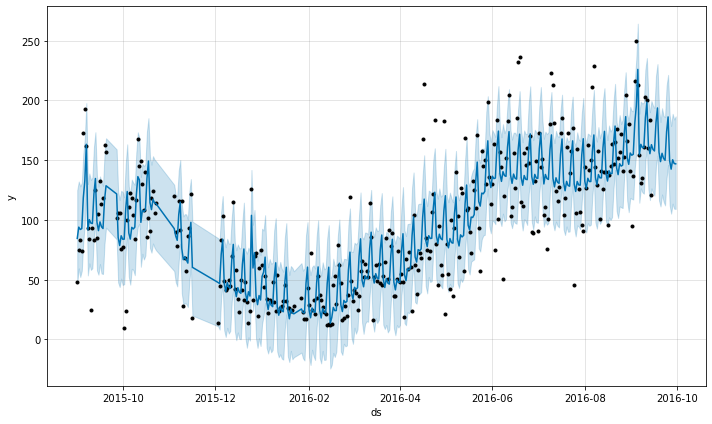

In [29]:
p.plot(forecast);

Visualize the forecast components to see the general trend, seasonalities, holidays:


Notice the `;`? Refer to this [GitHub issue](https://github.com/facebook/prophet/issues/503). 

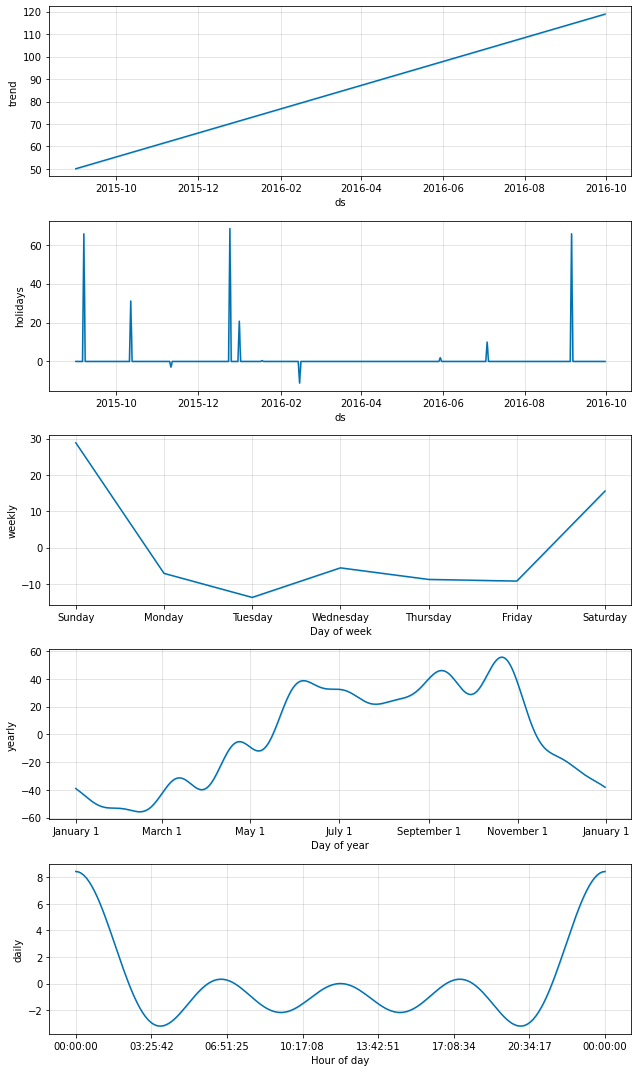

In [28]:
p.plot_components(forecast);

Visualize with plotly for interactive time series review:

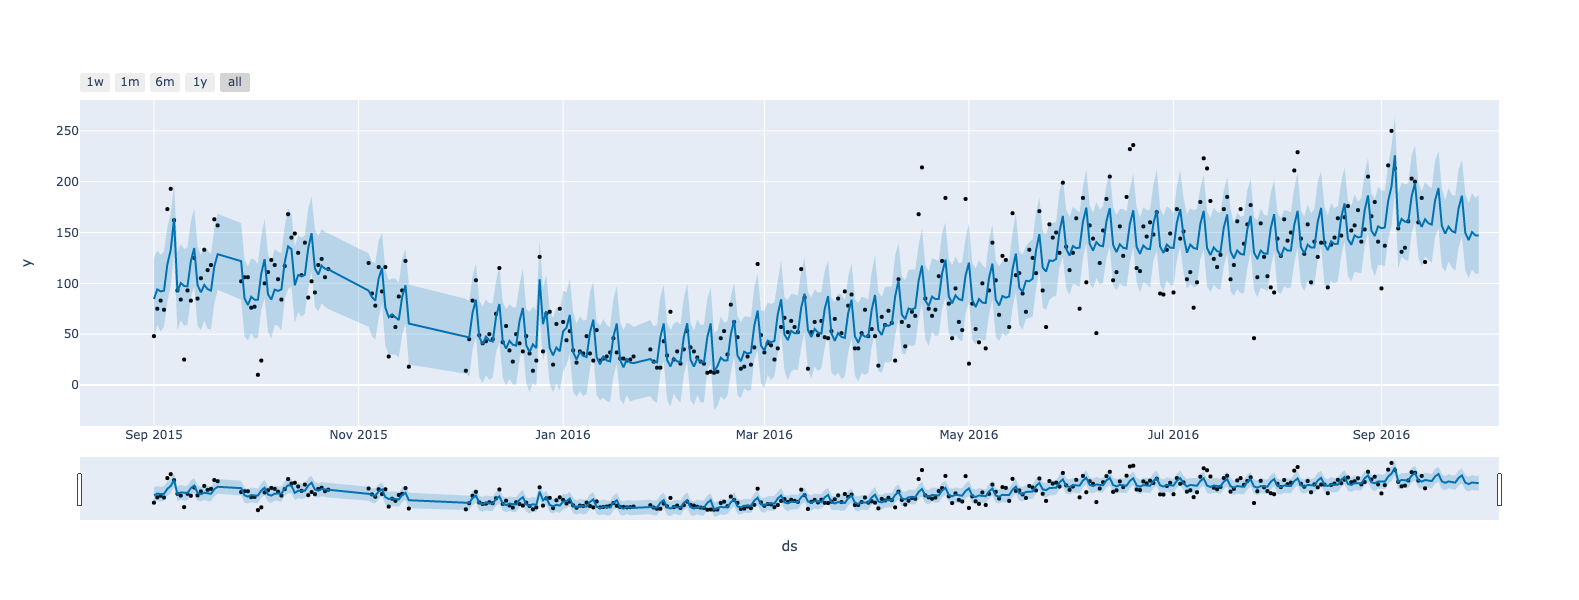

In [27]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(p, forecast)

---
## Create Forecast Model - All Series... In Parallel

Prophet does not have an input for indicating separate time series.  In order to fit all the time series and utilize available compute we will use the Python multiprocessing package.

### Create a function to fit a series

Return a dataframe for the entire series, including forecast horizon, that include the fitted forecast and confidence interval:

In [31]:
def run_prophet(series):
    p = Prophet(weekly_seasonality=True)
    p.add_country_holidays(country_name='US')
    p.fit(series)
    f = p.make_future_dataframe(periods = 16)
    f = p.predict(f)
    return f[['ds','yhat','yhat_lower','yhat_upper']]

### Test the function on a single series

In [32]:
test = run_prophet(seriesFrames[5])
test

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -8.66172
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        501.52    0.00098497        59.384           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       502.035   0.000369393       69.1758      0.2906           1      259   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     252       502.164    0.00044162       80.8457   4.794e-06       0.001      377  LS failed, Hessian reset 
     299       502.185   1.66096e-06       69.6783       0.739       0.739      437   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     323       502.187     4.319e-06        75.283   5.865e-08       0.001      509  LS failed, Hessian reset 
     346       502.188   1.68752e-08       64.5919      0.2348     0.05277      543   
Optimization terminat

ds        yhat  yhat_lower  yhat_upper
0   2015-09-01   93.321899   51.863481  129.947478
1   2015-09-02  101.207885   58.433923  143.017883
2   2015-09-03   97.696103   55.300401  138.559837
3   2015-09-04   96.595153   53.528451  139.332236
4   2015-09-05  120.751673   80.378960  160.078758
..         ...         ...         ...         ...
354 2016-09-26  176.328550  136.784962  220.750131
355 2016-09-27  171.313071  128.367752  214.146820
356 2016-09-28  180.287019  140.790327  222.651586
357 2016-09-29  177.863199  139.369096  219.175000
358 2016-09-30  177.850210  140.302766  217.434314

[359 rows x 4 columns]

### Setup Multiprocessing

In [33]:
from multiprocessing import Pool, cpu_count
from tqdm import tqdm

See how many cpu's are available to this notebook.  We chose `n1-standard-4` when setting up this notebook instance and expect to see 4 here:

In [36]:
cpu_count()

4

### Run all series in parallel

Three Things:
- Setup a pool that can use all the cpu's
- map the `run_prophet` function to each dataframe in the list `seriesFrames`
- Store the output from each series in a common list `predictions`

Bonus:
- Use the `tqdm` package to present a progress bar for the overall process of all series

In [39]:
pool = Pool(cpu_count())
predictions = list(tqdm(pool.imap(run_prophet, seriesFrames), total = len(seriesFrames)))
pool.close()
pool.join()

  0%|          | 0/12 [00:00<?, ?it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 10.



Initial log joint probability = -40.864

Initial log joint probability = -52.9409
Iteration  1. Log joint probability =     23.294. Improved by 64.158.
Iteration  1. Log joint probability =   0.526845. Improved by 53.4677.
Iteration  2. Log joint probability =    2.01758. Improved by 1.49073.
Iteration  3. Log joint probability =    2.06337. Improved by 0.045794.
Iteration  2. Log joint probability =    40.6787. Improved by 17.3847.
Iteration  4. Log joint probability =    22.0622. Improved by 19.9988.
Iteration  5. Log joint probability =    22.9785. Improved by 0.916336.
Iteration  6. Log joint probability =    23.0058. Improved by 0.0272692.
Iteration  3. Log joint probability =    41.5562. Improved by 0.877484.
Iteration  7. Log joint probability =    23.0871. Improved by 0.0813553.
Iteration  8. Log joint probability =    23.0949. Improved by 0.0077822.
Iteration  4. Log joint probability =     45.829. Improved by 4.2728.
Iteration  9. Log joint probability =    23.1133. Improved

  8%|▊         | 1/12 [00:04<00:49,  4.50s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -40.5909
Iteration  1. Log joint probability =    26.2809. Improved by 66.8718.
Iteration  2. Log joint probability =    41.4942. Improved by 15.2133.
Iteration  3. Log joint probability =     52.473. Improved by 10.9787.
Iteration  4. Log joint probability =    54.3205. Improved by 1.84757.
Iteration  5. Log joint probability =    54.8009. Improved by 0.480391.
Iteration  6. Log joint probability =    55.0825. Improved by 0.281544.
Iteration  7. Log joint probability =    55.0881. Improved by 0.00559737.
Iteration  8. Log joint probability =    55.1688. Improved by 0.0807577.
Iteration  9. Log joint probability =    55.1759. Improved by 0.00704621.
Iteration 10. Log joint probability =    55.2137. Improved by 0.0378079.
Iteration 11. Log joint probability =    55.2296. Improved by 0.0159051.
Iteration 12. Log joint probability =    55.2651. Improved by 0.0355626.
Iteration 13. Log joint probability =    55.3055. Improved by 0.0403724.
Iteration 14. Log

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Iteration 49. Log joint probability =     55.372. Improved by 2.41178e-06.
Iteration 50. Log joint probability =     55.372. Improved by 5.44158e-07.
Iteration 51. Log joint probability =     55.372. Improved by 1.01117e-06.
Iteration 52. Log joint probability =     55.372. Improved by 2.80546e-07.
Iteration 53. Log joint probability =     55.372. Improved by 3.36757e-07.
Iteration 54. Log joint probability =     55.372. Improved by 6.90367e-07.
Iteration 55. Log joint probability =     55.372. Improved by 2.37613e-07.
Iteration 56. Log joint probability =     55.372. Improved by 1.59131e-07.
Iteration 57. Log joint probability =     55.372. Improved by 1.61725e-07.
Iteration 58. Log joint probability =     55.372. Improved by 1.16933e-08.
Iteration 59. Log joint probability =     55.372. Improved by 4.50572e-08.
Iteration 60. Log joint probability =     55.372. Improved by 1.5795e-08.
Iteration 61. Log joint probability =     55.372. Improved by 1.14245e-08.
Iteration 62. Log joint pr

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.38731
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      87       600.164    0.00275665       167.766   1.685e-05       0.001      145  LS failed, Hessian reset 
      99       602.337    0.00164129       83.5421      0.4947      0.4947      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     159       602.572   1.13725e-06       72.0644   1.304e-08       0.001      280  LS failed, Hessian reset 
     170       602.572   3.64083e-08       62.0486      0.3366           1      297   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -8.0478
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.46235
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      85       513.153   0.000341895       54.0331   5.019e-06       0.001      145  LS failed, Hessian reset 
      99       513.163   4.81113e-06       48.3785           1           1      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132        513.17   2.67004e-05       73.6059   3.865e-07       0.001      239  LS failed, Hessian reset 
      92       520.663    0.00298032       120.658    2.63e-05       0.001      154  LS failed, Hessian reset 
      99       521.736    0.00148745       60.2842           1           1      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     170       513.172   1.24118e-08       6

 17%|█▋        | 2/12 [00:11<00:59,  5.91s/it]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -22.2998
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2060.46   0.000397075       52.1592           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


 58%|█████▊    | 7/12 [00:12<00:06,  1.23s/it]

     148       2061.13   0.000581777       70.8283   7.784e-06       0.001      236  LS failed, Hessian reset 
     199       2061.48   0.000471774       80.0736           1           1      302   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     221       2061.53   5.03273e-05       84.9021   6.676e-07       0.001      363  LS failed, Hessian reset 


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     247       2061.53     1.036e-06       65.1882   1.408e-08       0.001      433  LS failed, Hessian reset 
     257       2061.53    1.2831e-07       54.1978      0.5678      0.5678      443   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance

Initial log joint probability = -38.4092
Iteration  1. Log joint probability =    19.4803. Improved by 57.8895.
Iteration  2. Log joint probability =    40.9669. Improved by 21.4866.
Iteration  3. Log joint probability =    48.8691. Improved by 7.90222.
Iteration  4. Log joint probability =    49.9549. Improved by 1.08575.
Iteration  5. Log joint probability =    49.9889. Improved by 0.0340781.
Iteration  6. Log joint probability =    50.0329. Improved by 0.0439816.
Iteration  7. Log joint probability =    50.0486. Improved by 0.0157108.
Iteration  8. Log joint probability =    50.0646. Improved by 0.0159781.
Iteration  9. Log joint probability =    50.0757. Improved by 0.0111309.
Itera

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.15981
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      66       577.223    0.00167187       109.914    2.11e-05       0.001      116  LS failed, Hessian reset 
      99       577.969   0.000283063       61.4906      0.3301      0.3301      156   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     130       578.125   0.000340861       73.3439   5.241e-06       0.001      228  LS failed, Hessian reset 
     173       578.211   2.64883e-05       61.0748   3.561e-07       0.001      320  LS failed, Hessian reset 
     199       578.237   0.000519481       56.3772      0.7566      0.7566      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     227       578.243    2.7401e-06       65.8402   3.111e-08       0.001      427  LS failed, Hessian reset 
     245       578.243   1.57361e-08       56.7051       0.497   

100%|██████████| 12/12 [00:19<00:00,  1.62s/it]


### Review predictions for one of the series

In [38]:
predictions[0]

ds        yhat  yhat_lower  yhat_upper
0  2016-09-01   77.981838   32.096824  123.350576
1  2016-09-02  139.988952   97.120841  182.997090
2  2016-09-03  220.489021  175.036992  265.895969
3  2016-09-04  274.491658  227.676766  318.623547
4  2016-09-05  258.862315  208.710782  303.429954
5  2016-09-06  123.520849   80.677386  171.285916
6  2016-09-07  124.041599   75.277203  170.291257
7  2016-09-08   77.978107   34.660162  123.598088
8  2016-09-09  139.985221   94.640588  188.216462
9  2016-09-10  220.485290  173.153903  269.031474
10 2016-09-11  274.487927  230.725295  314.715215
11 2016-09-12  148.151055  102.340621  195.149898
12 2016-09-13  123.517117   78.799664  168.601945
13 2016-09-14  124.037867   75.892099  170.199117
14 2016-09-15   77.974376   33.523022  125.219873
15 2016-09-16  139.981490   88.653312  185.655463
16 2016-09-17  220.481559  175.770322  269.756294
17 2016-09-18  274.484196  229.059738  316.429880
18 2016-09-19  148.147324  100.003771  194.164421
19 2016-09-20  123.513386   77.228596  169.624336
20 2016-09-21  124.034136   77.838262  171.187383
21 2016-09-22   77.970645   34.044492  123.669498
22 2016-09-23  139.977759   96.006438  180.752483
23 2016-09-24  220.477828  174.957677  265.212045
24 2016-09-25  274.480465  230.535774  320.882935
25 2016-09-26  148.143592  103.981034  194.668780
26 2016-09-27  123.509655   75.203098  168.066355
27 2016-09-28  124.030405   75.216380  169.573181
28 2016-09-29   77.966914   30.397072  125.339670
29 2016-09-30  139.974028   91.305965  184.750491

## Store the Results back in BigQuery

### Concatenate The Predictions for Each Series
Create the `start_station_name` column

In [41]:
for i, p in enumerate(predictions):
    p['start_station_name'] = seriesNames[i]
    
output = pd.concat(predictions)
output

ds        yhat  yhat_lower  yhat_upper  \
0   2016-09-01   77.981838   32.096824  123.350576   
1   2016-09-02  139.988952   97.120841  182.997090   
2   2016-09-03  220.489021  175.036992  265.895969   
3   2016-09-04  274.491658  227.676766  318.623547   
4   2016-09-05  258.862315  208.710782  303.429954   
..         ...         ...         ...         ...   
354 2016-09-26   76.678990   51.226660  100.800475   
355 2016-09-27   76.062342   51.510838  101.416812   
356 2016-09-28   79.895369   54.579214  104.222856   
357 2016-09-29   77.252782   53.039400  102.627575   
358 2016-09-30   79.315578   53.095825  103.376684   

                                start_station_name  
0    Central Park North & Adam Clayton Powell Blvd  
1    Central Park North & Adam Clayton Powell Blvd  
2    Central Park North & Adam Clayton Powell Blvd  
3    Central Park North & Adam Clayton Powell Blvd  
4    Central Park North & Adam Clayton Powell Blvd  
..                                             ...  
354                    W 82 St & Central Park West  
355                    W 82 St & Central Park West  
356                    W 82 St & Central Park West  
357                    W 82 St & Central Park West  
358                    W 82 St & Central Park West  

[4391 rows x 5 columns]

### Load the Dataframe to BigQuery using Pandas GBQ

Reference for [Pandas GBQ](https://cloud.google.com/bigquery/docs/pandas-gbq-migration#loading_a_pandas_dataframe_to_a_table)

In [43]:
output.to_gbq(f"{DATANAME}.{NOTEBOOK}_prophet", PROJECT_ID, if_exists = 'replace')

4391 out of 4391 rows loaded., ?it/s]INFO:pandas_gbq.gbq:
100%|██████████| 1/1 [00:00<00:00, 865.70it/s]


### Use BigQuery to Transform The Results: Combine with Source Data for Series

In [45]:
query = f"""
CREATE OR REPLACE TABLE `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_prophet` AS
WITH
    SOURCE AS (
        SELECT *
        FROM `{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped`
    ),
    PROPHET AS (
        SELECT start_station_name, DATE(ds) as date, yhat, yhat_lower, yhat_upper
        FROM `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_prophet`
    )
SELECT *
FROM SOURCE
LEFT OUTER JOIN PROPHET
USING (start_station_name, date)
ORDER by start_station_name, date
"""
Tjob = bigquery.query(query = query)
Tjob.result()
(Tjob.ended-Tjob.started).total_seconds()

2.605

## Results

### Retrieve Test Data

In [49]:
query = f"""
SELECT
    date, 
    num_trips, 
    splits, 
    start_station_name, 
    yhat as predicted_num_trips
FROM `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_prophet`
WHERE splits = 'TEST'
"""
prophet = bigquery.query(query = query).to_dataframe()
prophet

date  num_trips splits  \
0    2016-09-15        132   TEST   
1    2016-09-16        175   TEST   
2    2016-09-17        269   TEST   
3    2016-09-18        272   TEST   
4    2016-09-19         39   TEST   
..          ...        ...    ...   
178  2016-09-26        102   TEST   
179  2016-09-27        105   TEST   
180  2016-09-28         72   TEST   
181  2016-09-29        143   TEST   
182  2016-09-30         42   TEST   

                                start_station_name  predicted_num_trips  
0    Central Park North & Adam Clayton Powell Blvd            77.974376  
1    Central Park North & Adam Clayton Powell Blvd           139.981490  
2    Central Park North & Adam Clayton Powell Blvd           220.481559  
3    Central Park North & Adam Clayton Powell Blvd           274.484196  
4    Central Park North & Adam Clayton Powell Blvd           148.147324  
..                                             ...                  ...  
178                    W 82 St & Central Park West            76.678990  
179                    W 82 St & Central Park West            76.062342  
180                    W 82 St & Central Park West            79.895369  
181                    W 82 St & Central Park West            77.252782  
182                    W 82 St & Central Park West            79.315578  

[183 rows x 5 columns]

### Review Custom Metrics with SQL

Some common metrics for evaluating forecasting effectiveness are 
- MAPE, or Mean Absolute Percentage Error
    - $\textrm{MAPE} = \frac{1}{n}\sum{\frac{\mid(actual - forecast)\mid}{actual}}$
- MAE, or Mean Absolute Error
     - $\textrm{MAE} = \frac{1}{n}\sum{\mid(actual - forecast)\mid}$
- MAE divide by average demand so it yields a % like MAPE
    - $\textrm{pMAE} = \frac{\sum{\mid(actual - forecast)\mid}}{\sum{actual}}$


It can be helpful to explicity caculate these to make comparison between datasets and models fair.  This section demonstration these calculation with SQL.

In [55]:
query = f"""
WITH
    FORECASTS AS (
        SELECT
            date, 
            num_trips, 
            splits, 
            start_station_name, 
            yhat as predicted_num_trips
        FROM `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_prophet`
        WHERE splits = 'TEST'
    ),
    DIFFS AS (
        SELECT 
            start_station_name, date, 'forecast' as time_series_type,
            predicted_num_trips as forecast_value,
            num_trips as actual_value,
            (num_trips - predicted_num_trips) as diff
        FROM FORECASTS    
    )
SELECT start_station_name, time_series_type, 
    AVG(ABS(diff)/actual_value) as MAPE,
    AVG(ABS(diff)) as MAE,
    SUM(ABS(diff))/SUM(actual_value) as pMAE,
    COUNT(diff) as n
FROM DIFFS
GROUP BY start_station_name, time_series_type
ORDER BY start_station_name, time_series_type    
"""
customMetrics = bigquery.query(query = query).to_dataframe()
customMetrics

start_station_name time_series_type      MAPE  \
0   Central Park North & Adam Clayton Powell Blvd         forecast  0.514783   
1                          Central Park S & 6 Ave         forecast  0.441341   
2                        Central Park W & W 96 St         forecast  0.435991   
3                    Central Park West & W 100 St         forecast  0.561961   
4                    Central Park West & W 102 St         forecast  0.406841   
5                     Central Park West & W 68 St         forecast  0.492278   
6                     Central Park West & W 72 St         forecast  0.595147   
7                     Central Park West & W 76 St         forecast  0.376168   
8                     Central Park West & W 85 St         forecast  0.915767   
9               Grand Army Plaza & Central Park S         forecast  0.392966   
10                   W 106 St & Central Park West         forecast  0.277747   
11                    W 82 St & Central Park West         forecast  0.372922   

          MAE      pMAE   n  
0   35.525808  0.229199  16  
1   92.373482  0.278653  16  
2   26.413009  0.267643  16  
3   14.146183  0.343458  16  
4   11.717727  0.226156  16  
5   44.777615  0.293023  16  
6   45.807013  0.251687  15  
7   28.335116  0.253984  16  
8   46.401447  0.378273   9  
9   47.318876  0.211308  15  
10  17.026719  0.255800  16  
11  29.470646  0.335370  16

Overall Metrics:

In [56]:
query = f"""
WITH
    FORECASTS AS (
        SELECT
            date, 
            num_trips, 
            splits, 
            start_station_name, 
            yhat as predicted_num_trips
        FROM `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_prophet`
        WHERE splits = 'TEST'
    ),
    DIFFS AS (
        SELECT 
            start_station_name, date, 'forecast' as time_series_type,
            predicted_num_trips as forecast_value,
            num_trips as actual_value,
            (num_trips - predicted_num_trips) as diff
        FROM FORECASTS    
    )
SELECT time_series_type, 
    AVG(ABS(diff)/actual_value) as MAPE,
    AVG(ABS(diff)) as MAE,
    SUM(ABS(diff))/SUM(actual_value) as pMAE,
    COUNT(diff) as n
FROM DIFFS
GROUP BY time_series_type
ORDER BY time_series_type     
"""
customMetricsOverall = bigquery.query(query = query).to_dataframe()
customMetricsOverall

time_series_type      MAPE        MAE      pMAE    n
0         forecast  0.465268  36.126132  0.267168  183

### Retrieve the Forecasting Data

In [60]:
query = f"""
SELECT *
FROM `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_prophet`
ORDER by start_station_name, date
"""
prophet = bigquery.query(query = query).to_dataframe()

Retrieve key dates for visualization:

In [61]:
query = f"""
WITH
    SPLIT AS (
        SELECT splits, min(date) as mindate, max(date) as maxdate
        FROM `{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped`
        GROUP BY splits
    ),
    TRAIN AS (
        SELECT mindate as start_date
        FROM SPLIT
        WHERE splits ='TRAIN'
    ),
    VAL AS (
        SELECT mindate as val_start
        FROM SPLIT
        WHERE splits = 'VALIDATE'
    ),
    TEST AS (
        SELECT mindate as test_start, maxdate as end_date, DATE_DIFF(maxdate, mindate, DAY)+1 as forecast_horizon
        FROM SPLIT
        WHERE splits = 'TEST'
    )
SELECT * EXCEPT(pos) FROM
(SELECT *, ROW_NUMBER() OVER() pos FROM TRAIN)
JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM VAL)
USING (pos)
JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM TEST)
USING (pos)
"""
keyDates = bigquery.query(query = query).to_dataframe()
keyDates

start_date   val_start  test_start    end_date  forecast_horizon
0  2013-07-01  2016-08-31  2016-09-15  2016-09-30                16

### Visualize The Time Series with Forecast

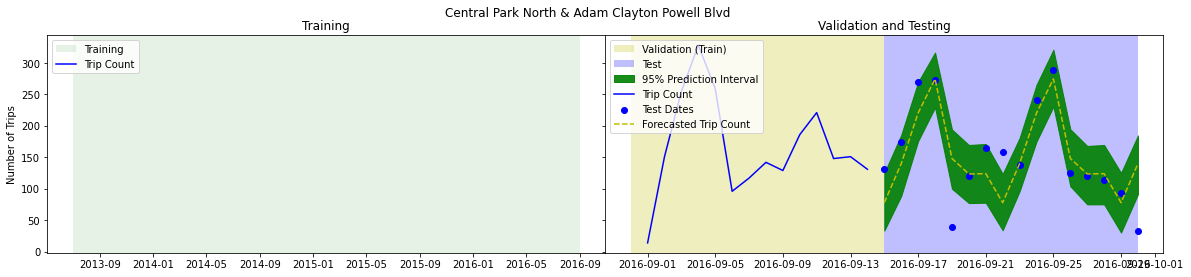

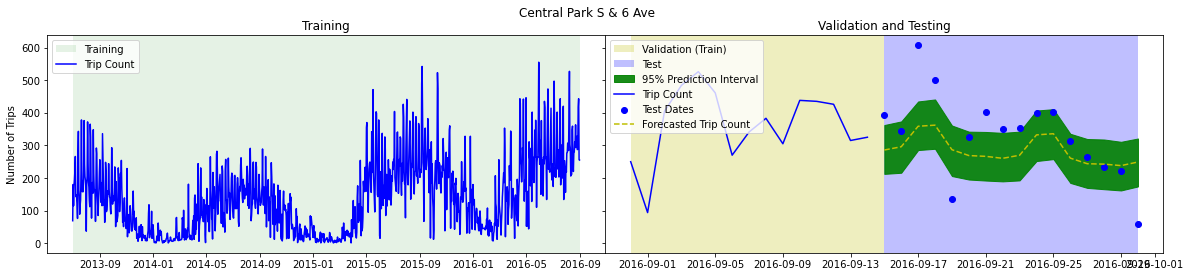

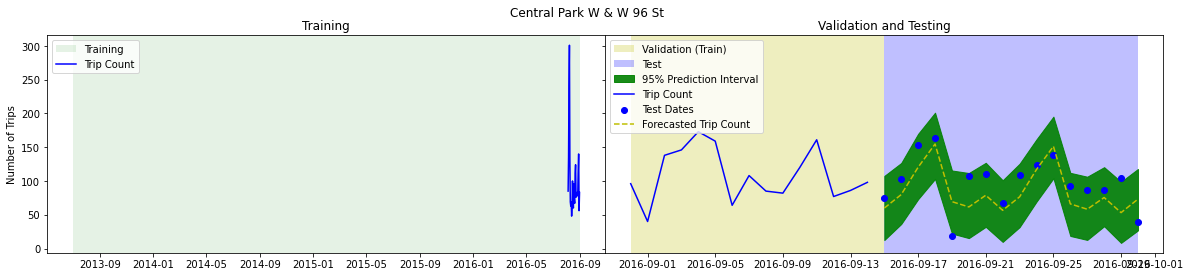

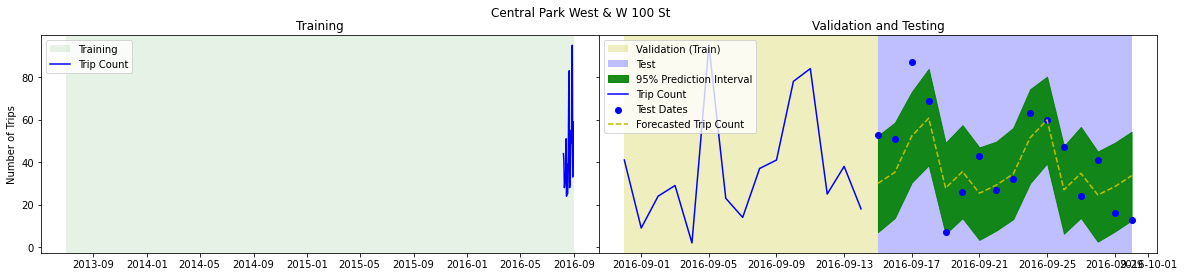

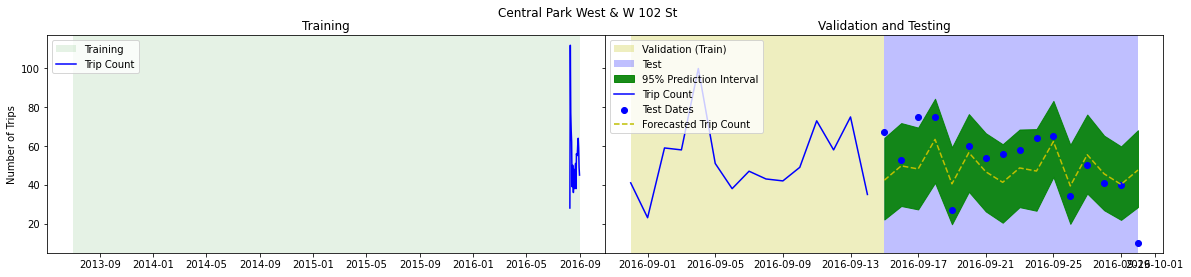

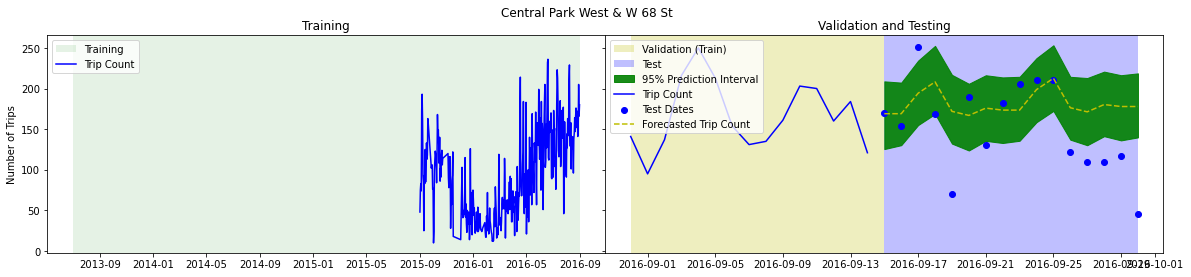

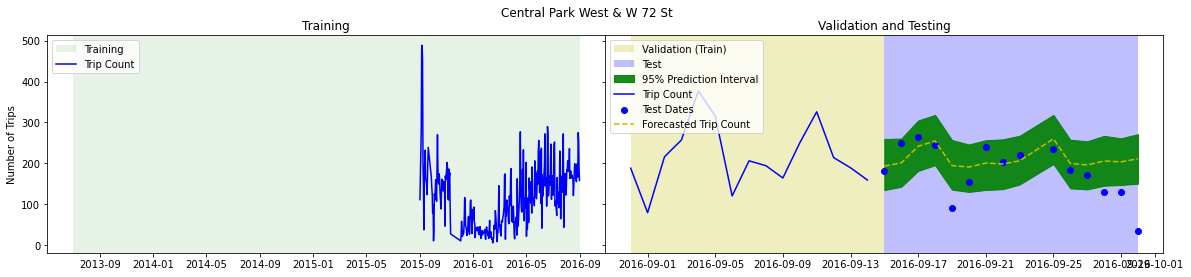

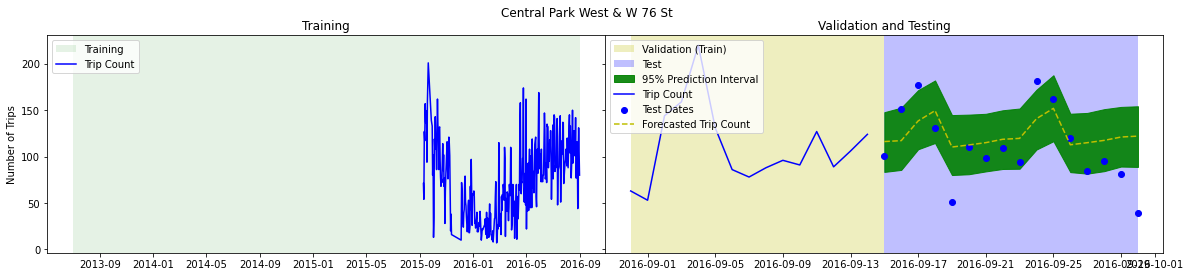

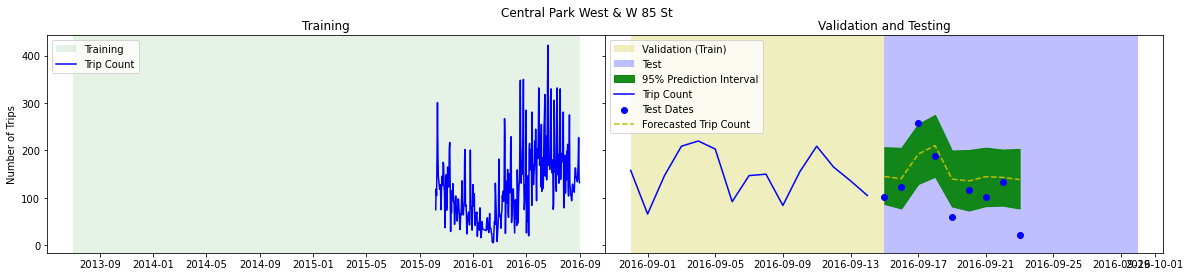

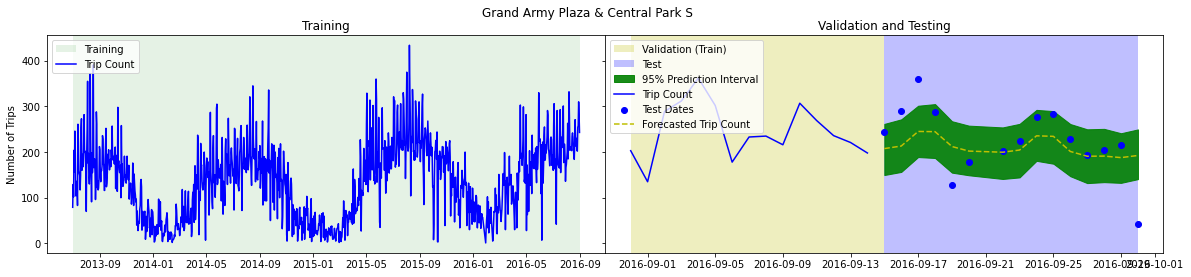

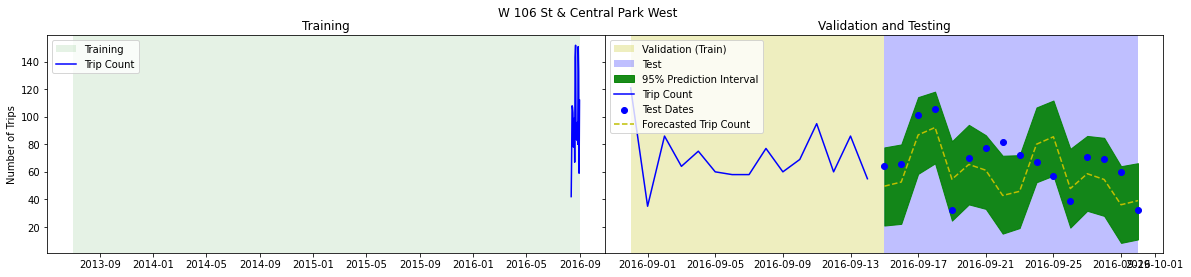

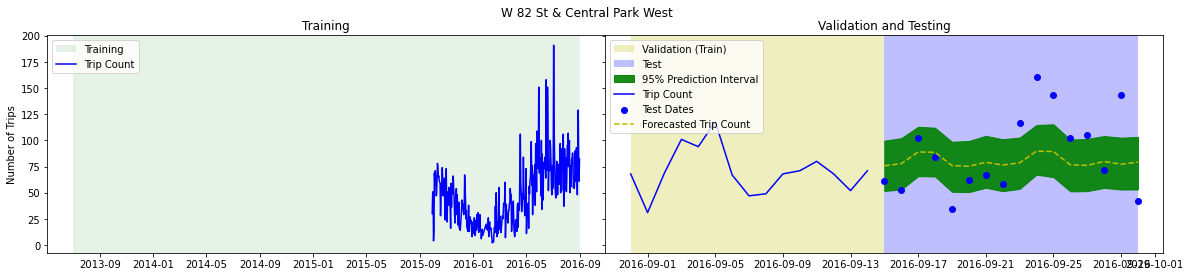

In [62]:
stations = prophet['start_station_name'].unique().tolist()
for s, st in enumerate(stations):
    # setup plot area
    fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharex=False, sharey=True)
    fig.subplots_adjust(wspace=0)
    
    # data
    traindf = prophet[(prophet['start_station_name'] == st) & (prophet['splits'] == 'TRAIN')]
    valdf = prophet[(prophet['start_station_name'] == st) & (prophet['splits'] == 'VALIDATE')]
    testdf = prophet[(prophet['start_station_name'] == st) & (prophet['splits'] == 'TEST')]
    #fit_testdf = autoML[(autoML['start_station_name'] == st) & (autoML['splits'] == 'TEST')]
    
    # regions
    axes[0].axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.1, label = 'Training')
    axes[1].axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.25, label = 'Validation (Train)')
    axes[1].axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.25, label = 'Test')
    axes[1].fill_between(testdf['date'], testdf['yhat_lower'], testdf['yhat_upper'], color = 'g', alpha = 0.9, label = '95% Prediction Interval')
    
    
    # lines and dots
    axes[0].plot(traindf['date'], traindf['num_trips'], color = 'b', label = 'Trip Count')
    axes[1].plot(valdf['date'], valdf['num_trips'], color = 'b', label = 'Trip Count')
    axes[1].scatter(testdf['date'], testdf['num_trips'], color = 'b', label = 'Test Dates')
    
    axes[1].plot(testdf['date'], testdf['yhat'], color = 'y', label = 'Forecasted Trip Count', linestyle='dashed')
    #axes[1].scatter(testdf['date'], testdf['yhat'], color = 'y')
    
    # labels
    axes[0].set_ylabel('Number of Trips')
    axes[0].set_title('Training')
    axes[1].set_title('Validation and Testing')
    axes[1].legend(loc = 'upper left')
    axes[0].legend(loc = 'upper left')
    plt.suptitle(st)

    # display result
    plt.show()

---
## Remove Resources
see notebook "99 - Cleanup"